In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
test_df.head()

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,16,226,1412,3476,12,7,2,0,1,0
1,2,841,1,0.5,1,4,1,61,0.8,191,...,12,746,857,3895,6,0,7,1,0,0
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,4,1270,1366,2396,17,10,10,0,1,1
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,20,295,1752,3893,10,0,7,1,1,0
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,18,749,810,1773,15,8,7,1,0,1


In [5]:
test_df.drop('id',axis=1,inplace=True)

In [6]:
train_y = train_df['price_range']
train_df.drop('price_range',axis=1,inplace=True)

In [7]:
train_df.shape

(2000, 20)

In [8]:
complete = pd.concat([train_df,test_df],axis=0)

<AxesSubplot:>

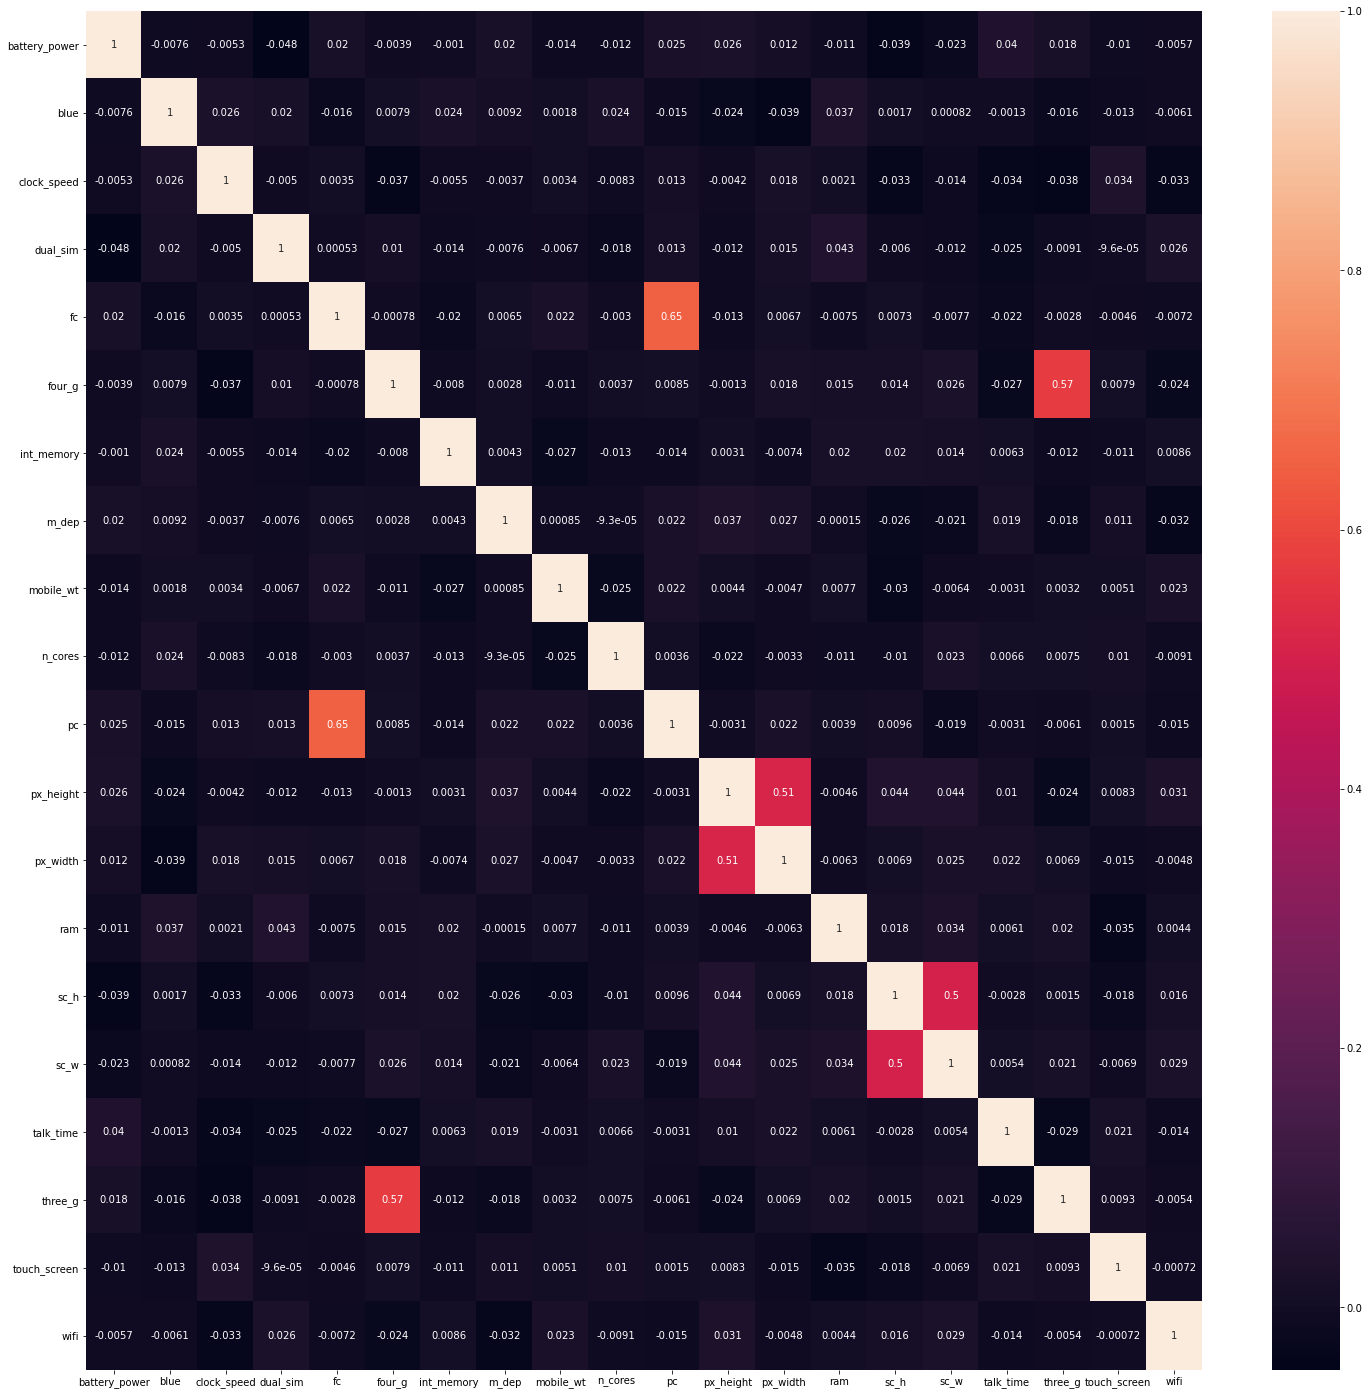

In [9]:
plt.figure(figsize= (25,25))
sns.heatmap(complete.corr(),annot=True)

Not that much data is correlated lets do feature selection 

<AxesSubplot:>

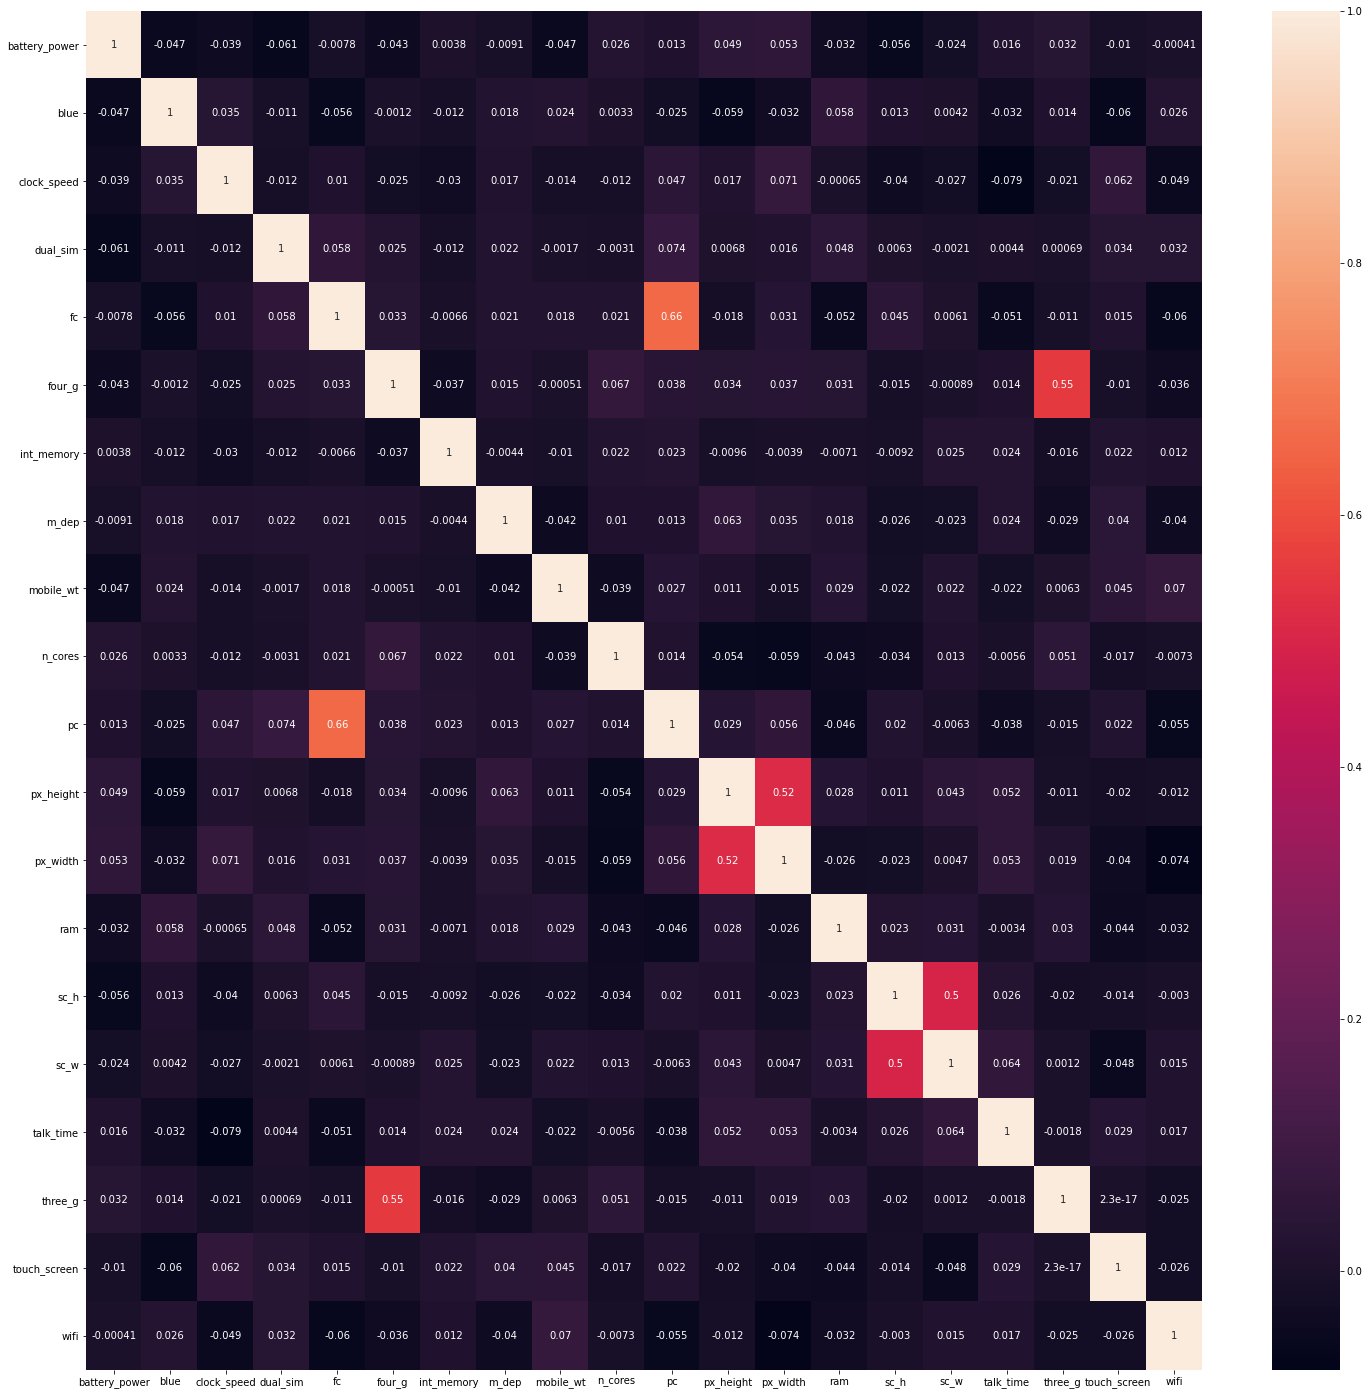

In [10]:
plt.figure(figsize= (25,25))
sns.heatmap(test_df.corr(),annot=True)

##### Feature selection

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clas1 = SVC(random_state=0)

clas = RandomForestClassifier(random_state=49)
ref = RFECV(estimator=clas,cv=5,step=1,scoring='accuracy')

In [12]:
ref.fit(train_df,train_y)

RFECV(cv=5, estimator=RandomForestClassifier(random_state=49),
      scoring='accuracy')

In [13]:
ref.n_features_

4

In [14]:
train_df.columns[ref.support_]

Index(['battery_power', 'px_height', 'px_width', 'ram'], dtype='object')

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

cls = SelectKBest(chi2,k=10).fit(train_df,train_y)

In [16]:
df_sc = pd.DataFrame(cls.scores_)
df_col = pd.DataFrame(train_df.columns)

In [17]:
fea= pd.concat([df_col,df_sc],axis=1)
fea.columns = ['spec','score']

In [18]:
print(fea.nlargest(10,'score'))

             spec          score
13            ram  931267.519053
11      px_height   17363.569536
0   battery_power   14129.866576
12       px_width    9810.586750
8       mobile_wt      95.972863
6      int_memory      89.839124
15           sc_w      16.480319
16      talk_time      13.236400
4              fc      10.135166
14           sc_h       9.614878


lets choose 6 specs
Lets get the maximum value and minimum value for this to mention in deployement

In [19]:
inter = ['ram','px_height','battery_power','px_width','mobile_wt','int_memory']

for i in inter:
    print(i, 'max:', max(train_df[i]),'min:', min(train_df[i]) )
     
    

ram max: 3998 min: 256
px_height max: 1960 min: 0
battery_power max: 1998 min: 501
px_width max: 1998 min: 500
mobile_wt max: 200 min: 80
int_memory max: 64 min: 2


In [20]:
for i in train_df.columns:
    if i not in inter:
        train_df.drop(i,axis=1,inplace=True)

In [21]:
for i in test_df.columns:
    if i not in inter:
        test_df.drop(i,axis=1,inplace=True)

In [22]:
train_df

,battery_power,int_memory,mobile_wt,px_height,px_width,ram
0,842,7,188,20,756,2549
1,1021,53,136,905,1988,2631
2,563,41,145,1263,1716,2603
3,615,10,131,1216,1786,2769
4,1821,44,141,1208,1212,1411
...,...,...,...,...,...,...
1995,794,2,106,1222,1890,668
1996,1965,39,187,915,1965,2032
1997,1911,36,108,868,1632,3057
1998,1512,46,145,336,670,869


In [23]:
from sklearn.model_selection import train_test_split
X_tr,X_te,Y_tr,Y_te = train_test_split(train_df,train_y,test_size=0.3,random_state=42)



In [24]:
## lets train using 6 values

from sklearn.svm import SVC

cls = SVC(random_state=0)
cls.fit(X_tr,Y_tr)


SVC(random_state=0)

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(Y_te,cls.predict(X_te))

0.9533333333333334

In [28]:
###we are getting 0.95 accuracy 

In [29]:
cls1 = SVC(random_state=0)
cls1.fit(train_df,train_y)

SVC(random_state=0)

In [30]:
pre = cls.predict(test_df)

In [31]:
pre

array([3, 3, 2, 3, 1, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0, 2, 1, 3, 2, 1, 3,
       1, 1, 3, 0, 2, 0, 3, 0, 2, 0, 3, 0, 1, 1, 3, 1, 2, 1, 1, 2, 0, 0,
       0, 1, 0, 3, 1, 2, 1, 0, 3, 0, 3, 1, 3, 1, 1, 3, 3, 3, 0, 1, 1, 1,
       1, 3, 1, 2, 1, 2, 2, 3, 3, 0, 2, 0, 2, 3, 0, 3, 3, 0, 3, 0, 3, 1,
       3, 0, 1, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 0, 0, 3, 0, 2, 0, 1, 2, 3,
       3, 3, 1, 3, 3, 3, 3, 2, 3, 0, 0, 3, 2, 1, 2, 0, 3, 2, 3, 1, 0, 2,
       1, 1, 3, 1, 1, 0, 3, 2, 1, 2, 1, 2, 2, 3, 3, 3, 2, 3, 2, 3, 1, 0,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 2, 1, 0, 1,
       0, 0, 1, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 0, 1, 0, 3, 1, 0, 2, 2,
       2, 3, 1, 1, 3, 2, 3, 2, 2, 1, 0, 0, 1, 2, 0, 2, 3, 3, 0, 2, 0, 3,
       2, 3, 3, 1, 0, 1, 0, 3, 0, 1, 0, 2, 2, 1, 2, 1, 3, 0, 3, 1, 2, 0,
       0, 2, 1, 3, 3, 3, 1, 1, 3, 0, 0, 2, 3, 3, 1, 3, 1, 1, 3, 2, 1, 2,
       3, 3, 3, 1, 0, 1, 2, 3, 1, 1, 3, 2, 0, 3, 0, 0, 2, 0, 0, 3, 2, 3,
       3, 2, 1, 3, 3, 2, 3, 1, 2, 1, 2, 0, 2, 3, 1,

In [32]:
import pickle
pickle.dump(cls1,open('model.pkl','wb'))

In [33]:
train_df

,battery_power,int_memory,mobile_wt,px_height,px_width,ram
0,842,7,188,20,756,2549
1,1021,53,136,905,1988,2631
2,563,41,145,1263,1716,2603
3,615,10,131,1216,1786,2769
4,1821,44,141,1208,1212,1411
...,...,...,...,...,...,...
1995,794,2,106,1222,1890,668
1996,1965,39,187,915,1965,2032
1997,1911,36,108,868,1632,3057
1998,1512,46,145,336,670,869
